# Practico Mentoria - Aprendizaje No Supervisado

El objectivo de este practico es realizar [Clustering](https://es.wikipedia.org/wiki/Algoritmo_de_agrupamiento) sobre el Dataset de las Caracteristicas de los jugadores.

De forma de juntar en los clusters a los jugadores con caracteristicas similares, y en particular de este practico analizar si estos clusters se corresponden con la posicion en la que juegan estos jugadores.

---

### Importaciones

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import scikitplot as skplt

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')



In [3]:
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [4]:
# Seteamos una semilla para Reproducibilidad
np.random.seed(1)

---

### Carga del Dateset

In [5]:
player_df = pd.read_csv('./Datasets/football_player_full.csv', index_col='player_name')

#player_df.set_index('player_name', inplace=True)
print("Shape 'player_df' = {}".format(player_df.shape))

# Copy Dataframe
player2_df = player_df.copy(deep=False)

Shape 'player_df' = (9925, 36)


In [6]:
player_df.sample(10)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,position
player_name,,,,,,,,,,,,,,,,,,,,,
Ariel Borysiuk,66.12,74.38,56.92,49.79,49.38,67.25,58.88,64.08,45.79,52.38,...,49.21,51.58,63.58,63.08,12.71,13.04,18.71,15.54,13.04,MID
Sava Miladinovic Bento,58.00,64.43,51.07,44.86,42.93,58.14,46.21,58.29,50.64,52.86,...,49.50,41.64,46.57,40.07,8.00,8.00,8.00,7.00,14.00,MID
Dusan Tadic,78.16,81.88,81.52,68.36,56.64,78.60,69.84,81.36,79.72,73.08,...,76.28,39.96,35.56,27.56,10.16,10.16,12.56,8.16,15.16,MID
Samuel Souprayen,64.24,71.76,58.29,20.76,57.19,56.90,22.10,55.71,61.67,31.67,...,42.71,65.62,65.19,66.90,8.33,10.95,15.19,14.19,14.19,DEF
Daniele Croce,67.68,67.68,63.32,51.58,44.74,72.16,53.89,66.16,54.95,58.74,...,59.74,52.26,56.89,59.53,11.74,11.74,5.74,7.74,12.74,MID
John Arne Riise,76.32,77.64,84.00,60.82,67.05,78.32,75.05,69.41,74.05,77.55,...,70.59,75.45,79.59,80.59,13.27,10.09,33.14,13.50,13.68,DEF
Saidy Janko,62.13,76.53,58.73,40.60,56.73,51.20,34.27,67.07,41.73,36.27,...,51.20,58.53,65.87,64.60,5.27,9.27,7.27,13.27,7.27,DEF
Helder Postiga,76.04,76.93,59.33,71.19,78.19,64.56,78.56,73.56,65.81,52.85,...,70.59,25.37,28.11,27.19,12.00,9.81,20.67,16.37,14.59,FW
Denzel Slager,61.50,70.75,60.25,59.00,43.00,58.75,59.00,65.12,64.00,48.00,...,50.00,20.62,20.00,21.00,14.00,8.00,11.00,11.00,15.00,FW


In [7]:
player_df.dtypes

overall_rating        float64
potential             float64
crossing              float64
finishing             float64
heading_accuracy      float64
short_passing         float64
volleys               float64
dribbling             float64
curve                 float64
free_kick_accuracy    float64
long_passing          float64
ball_control          float64
acceleration          float64
sprint_speed          float64
agility               float64
reactions             float64
balance               float64
shot_power            float64
jumping               float64
stamina               float64
strength              float64
long_shots            float64
aggression            float64
interceptions         float64
positioning           float64
vision                float64
penalties             float64
marking               float64
standing_tackle       float64
sliding_tackle        float64
gk_diving             float64
gk_handling           float64
gk_kicking            float64
gk_positio

In [8]:
# Guardamos la lista de la posicion de los jugadores

player_position_list = player_df.position.tolist()

In [9]:
# function to get unique values 
def unique(list1): 
    x = np.array(list1) 
    print(np.unique(x)) 
    
unique(player_position_list) 

['DEF' 'FW' 'GK' 'MID']


In [10]:
player_df = player_df[[
    'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
    'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
    'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility',
    'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength',
    'long_shots', 'aggression', 'interceptions', 'positioning', 'vision',
    'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
    'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
]]

In [11]:
player_df.dtypes

overall_rating        float64
potential             float64
crossing              float64
finishing             float64
heading_accuracy      float64
short_passing         float64
volleys               float64
dribbling             float64
curve                 float64
free_kick_accuracy    float64
long_passing          float64
ball_control          float64
acceleration          float64
sprint_speed          float64
agility               float64
reactions             float64
balance               float64
shot_power            float64
jumping               float64
stamina               float64
strength              float64
long_shots            float64
aggression            float64
interceptions         float64
positioning           float64
vision                float64
penalties             float64
marking               float64
standing_tackle       float64
sliding_tackle        float64
gk_diving             float64
gk_handling           float64
gk_kicking            float64
gk_positio

In [12]:
player_df.sample(10)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_name,,,,,,,,,,,,,,,,,,,,,
Rolando Mandragora,60.93,73.13,47.87,44.33,48.07,69.33,41.67,60.07,49.67,33.67,...,65.07,31.67,46.67,57.00,52.73,12.67,13.67,8.67,13.67,15.67
Daniel Pinillos,59.71,66.14,59.57,32.14,48.14,48.29,33.14,52.29,57.57,39.14,...,43.86,46.14,57.86,63.57,70.43,6.14,15.14,10.14,12.14,6.14
Stopira,60.25,65.00,56.00,28.00,32.00,49.00,32.00,44.00,47.00,42.00,...,51.00,45.00,62.00,59.50,66.00,8.00,13.00,11.00,13.00,5.00
Kakha Kaladze,78.50,83.10,67.30,32.80,77.10,71.20,46.00,51.70,44.00,48.30,...,61.00,64.20,81.90,81.60,72.70,11.00,15.30,49.10,14.60,17.80
Sergi Darder,69.43,75.61,48.91,39.13,35.65,77.17,36.04,63.83,61.87,54.26,...,75.00,38.26,52.61,64.48,61.13,6.26,9.26,5.26,13.26,5.26
Zeljko Brkic,75.00,77.12,18.50,19.00,17.50,32.71,16.58,20.17,17.88,18.42,...,27.33,31.54,19.00,19.92,20.92,80.58,70.00,59.50,76.88,78.92
Stephen Elliott,66.50,70.93,52.79,67.14,65.64,59.79,61.14,64.21,52.00,47.71,...,64.93,63.43,32.50,31.43,25.00,13.57,10.79,22.79,9.29,9.43
Adil Ramzi,66.17,66.17,61.67,55.67,50.00,71.00,54.00,69.33,49.00,70.00,...,70.67,75.00,48.67,33.33,35.33,12.00,6.00,10.00,10.00,9.00
Igor Bubnjic,69.47,76.18,28.76,20.59,68.12,45.65,30.12,36.12,34.76,34.12,...,34.06,43.12,74.12,75.59,72.29,11.76,11.76,13.76,12.76,4.76


---

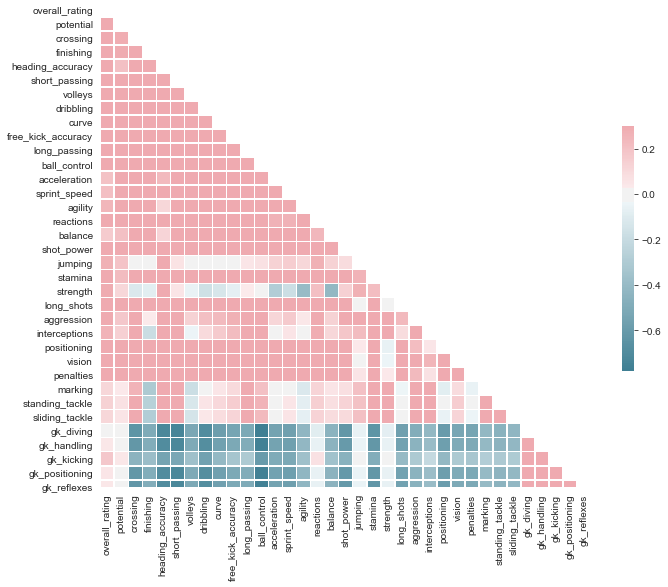

In [13]:
def plot_corr(player2_df):
    corr = player2_df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

plot_corr(player2_df)

> ### Aplicar Clustering sobre las features de los jugadores

Usar [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) para el clustering.

Probar primero con 4 clusters, este numero se debe a cantidad de clases con respecto a la posicion de los jugadores:
* **GK**: Goalkeeper (Arquero)
* **DEF**: Defenser (Defensor)
* **MID**: Midfielder (Mediocampistas)
* **FW**: Forward (Delantero)

Luedo de hacer clustering, ver cuantos elementos tiene cada cluster.

In [14]:
kmeans=KMeans(n_clusters=4).fit(player_df)
print(kmeans)
print('Suma de los cuadrados de las distancias al clusters / Inertia: ', kmeans.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
Suma de los cuadrados de las distancias al clusters / Inertia:  25234814.267621763


Text(0.5, 1.0, 'Inercia de los k-means vs clusters')

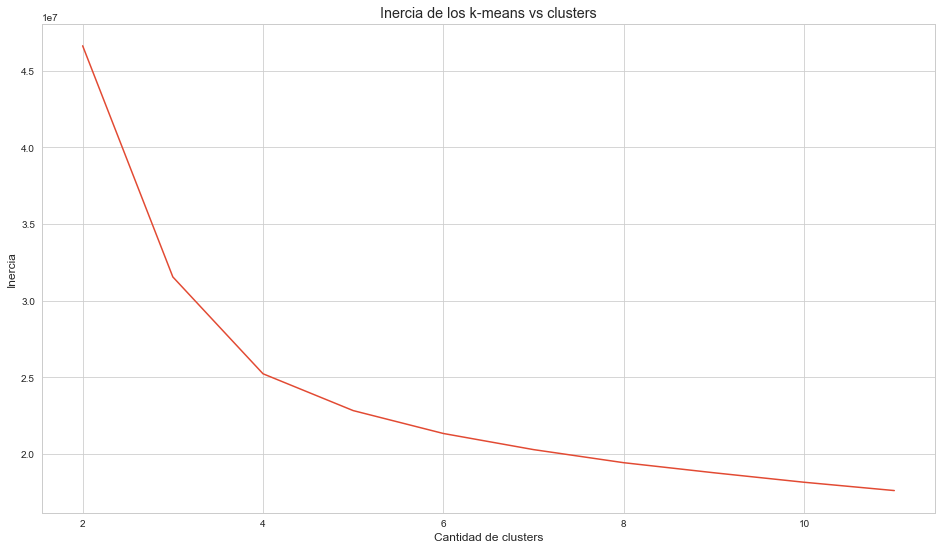

In [15]:
scores = [KMeans(n_clusters=i+2).fit(player_df).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Cantidad de clusters')
plt.ylabel("Inercia")
plt.title("Inercia de los k-means vs clusters")

In [16]:
print('Mostramos las coordenadas de los centroides')
kmeans.cluster_centers_

Mostramos las coordenadas de los centroides


array([[64.08988403, 69.84300786, 46.49642349, 31.88138421, 61.69737374,
        57.39560793, 32.9628208 , 47.00283577, 39.22787505, 37.56971193,
        52.72996633, 55.70340067, 61.74582866, 63.05716798, 56.9231388 ,
        60.4104003 , 60.17333333, 50.74353161, 67.35137673, 65.56865694,
        71.00908343, 37.04451178, 66.50736251, 62.03877666, 40.89347924,
        46.62543584, 44.32420127, 63.23297793, 65.92087542, 63.73903853,
         9.97573887, 11.1563786 , 14.6909278 , 11.3010737 , 11.21983539],
       [67.21331147, 72.81909584, 57.24261266, 64.68939817, 57.4087279 ,
        63.01983172, 60.3352567 , 68.23450371, 58.84691671, 53.19196235,
        53.21686823, 68.26194238, 73.3655733 , 73.24033657, 71.49944381,
        64.5250656 , 68.42403594, 67.48299201, 64.59006275, 64.7340502 ,
        62.69759555, 61.04813177, 51.91968625, 35.61887621, 65.10920422,
        60.96377638, 61.82029093, 27.62692812, 31.00964347, 28.32905305,
         9.9503223 , 11.42658871, 15.13956075, 11.

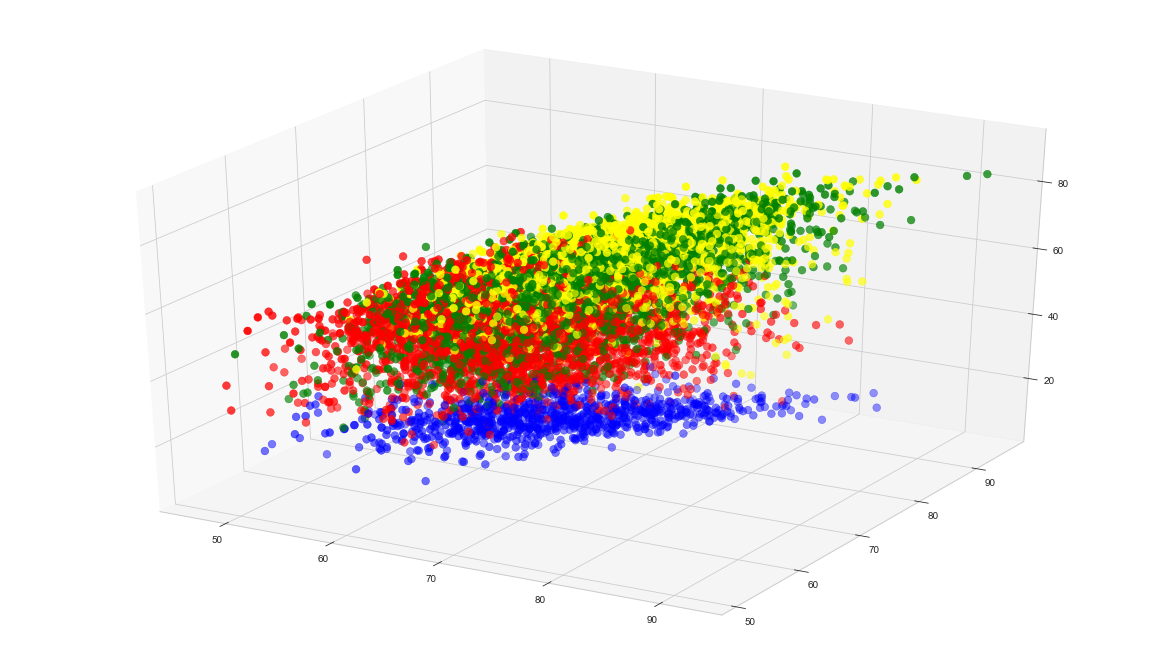

In [17]:
labels = kmeans.predict(player_df)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(player_df.iloc[:, 0], player_df.iloc[:, 1], player_df.iloc[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [18]:
pd.DataFrame(player2_df.position.value_counts()) 

,position
DEF,3664
MID,3473
FW,1919
GK,869


In [19]:
pd.DataFrame(pd.DataFrame(labels, columns = ['cluster']).cluster.value_counts())

,cluster
1,3506
3,2877
0,2673
2,869


In [20]:
copy =  pd.DataFrame()
copy['position']=player2_df['position'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['position']=copy.groupby('label').size()
cantidadGrupo.sort_values(by=['position'], ascending=False)

,color,position
1,green,3506
3,yellow,2877
0,red,2673
2,blue,869


> ##### Evaluar resultados

Evaluar los resultados del clustering usando una medida como la [Pureza](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html).


**Hint 1**: Puede que en los clusters haya confusion entre las distintas posiciones dentro del campo de juego, esto no esta mal. Ya que hay que recordar que las posiciones estan simplicadas.


**Hint 2**: Un indicador de mala calidad es que haya clusters muy chiquitos y uno muy grande, lo cual indica que en el espacio no se distinguen bien grupos separados y hay que usar otro espacio.

In [25]:
matriz = metrics.cluster.contingency_matrix(player_position_list, labels)
print(matriz)

[[2417    0    0 1247]
 [   3 1881    0   35]
 [   0    0  869    0]
 [ 253 1625    0 1595]]


In [28]:
print('Pureza: {}'.format(matriz.max(axis = 1).sum() / matriz.sum()))

Pureza: 0.6843324937027708


In [29]:
from sklearn.metrics.cluster import normalized_mutual_info_score

print('NMI: {}'.format(normalized_mutual_info_score(player_position_list, labels)))


from sklearn.metrics.cluster import adjusted_rand_score

print('Rand index: {}'.format(adjusted_rand_score(player_position_list, labels)))

NMI: 0.5629166802850829
Rand index: 0.4033761167152728


> ### Diferentes numero de clusters

Usar diferentes numero de clusters, especialmente numeros altos, para observar las subdivisiones de las clases, y que clases se confunden mas.


**Nota**: Las posiciones asignadas a los jugadores son simplificadas, esto quiere decir que al hacer mas de 4 clusters podemos llegar descubrir posiciones mas especificas dentro del campo de juego (por ejemplo: Defensor central, Lateral derecho/izquierdo, Mediocampista defensivo/ofensivo, etc.)


**Recordar**: Calcular la Pureza para analizar si tener una mayor cantidad de clusters da mejores resultados.

In [33]:
for bucle in range(2, 10):
    km_pred = KMeans(n_clusters = bucle, random_state = 42).fit_predict(player_df)
    km_pred
    contingency_matrix = metrics.cluster.contingency_matrix(player_position_list, km_pred)
    print('Pureza para k={}: {}'.format(bucle, contingency_matrix.max(axis = 1).sum() / contingency_matrix.sum()))


Pureza para k=2: 1.0
Pureza para k=3: 0.8798992443324937
Pureza para k=4: 0.6843324937027708
Pureza para k=5: 0.5802518891687657
Pureza para k=6: 0.4738539042821159
Pureza para k=7: 0.469823677581864
Pureza para k=8: 0.39476070528967255
Pureza para k=9: 0.374911838790932


> ### Subconjunto de Features

Probar diferentes subconjunto de caracteristicas del dataset para analizar si los resultados mejoran.

Por ejemplo, probar con el siguiente subconjunto de caracteristicas:
* `gk_diving`
* `gk_handling`
* `gk_kicking`
* `gk_positioning`
* `standing_tackle`
* `sliding_tackle`
* `short_passing`
* `vision`
* `finishing`
* `volleys`

Tambien probar con otros subconjuntos.


**Recordar**: Calcular la Pureza

In [34]:
player_df_subconjunto = player_df[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'standing_tackle',
                         'sliding_tackle', 'short_passing', 'vision', 'finishing', 'volleys']]

In [35]:
for bucle in range(2, 10):
    km_pred = KMeans(n_clusters = bucle, random_state = 42).fit_predict(player_df_subconjunto)
    km_pred
    contingency_matrix = metrics.cluster.contingency_matrix(player_position_list, km_pred)
    print('Pureza para k={}: {}'.format(bucle, contingency_matrix.max(axis = 1).sum() / contingency_matrix.sum()))

Pureza para k=2: 1.0
Pureza para k=3: 0.8428211586901764
Pureza para k=4: 0.7182871536523929
Pureza para k=5: 0.6211586901763224
Pureza para k=6: 0.5028715365239295
Pureza para k=7: 0.4777833753148615
Pureza para k=8: 0.42670025188916877
Pureza para k=9: 0.39788413098236775


> ### Uso de Embedding

Aplicar el uso de embeddings, por ejemplo [PCA](https://es.wikipedia.org/wiki/PCA), para comparar que sucede en ese espacio en comparacion con lo que sucede en el espacio original.

In [ ]:
# TODO



---

**Comunicación de Resultados**

Se pide que toda esta información no quede plasmada solamente en un Jupyter Notebook, sino que se diagrame una comunicación en formato textual o interactivo (Google Docs, PDF o Markdown por ejemplo).

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase.